## Import Library 

In [122]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

## Capturing Image From Webcam

In [125]:
# Load Haar Cascade 
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
DATASET_DIR = './dataset'
os.makedirs(DATASET_DIR, exist_ok=True)

In [126]:
# Initialize webcam
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Could not access the webcam.")
    exit()

while True:
    person_name = input("Enter the person's name (or type 'done' to finish): ").strip()
    if person_name.lower() == 'done':
        print("Dataset collection complete!")
        break

    person_dir = os.path.join(DATASET_DIR, person_name)
    if os.path.exists(person_dir):
        print(f"Images for {person_name} already exist. Skipping...")
        continue
    os.makedirs(person_dir, exist_ok=True)

    print(f"Collecting images for {person_name}. Press 'q' to stop.")
    count = 0

    while count < 100:
        ret, frame = cap.read()
        if not ret:
            print("Error: Could not read frame from webcam.")
            break

        # Convert to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect faces
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(50, 50))

        for (x, y, w, h) in faces:
            padding = 10
            x1, y1 = max(0, x - padding), max(0, y - padding)
            x2, y2 = min(frame.shape[1], x + w + padding), min(frame.shape[0], y + h + padding)

            # Draw rectangle around face
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Save the cropped face
            face_roi = frame[y1:y2, x1:x2]
            img_path = os.path.join(person_dir, f"{person_name}_{count}.jpg")
            cv2.imwrite(img_path, face_roi)
            count += 1
            print(f"Captured {count}/100 images for {person_name}")

            if count >= 100:
                break

        # Display the frame
        cv2.imshow("Face Capture - Press 'q' to Quit", frame)

        # Quit when 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


Enter the person's name (or type 'done' to finish):  done


Dataset collection complete!


## Data Preprocessing

In [104]:
# Get class labels from dataset folder names
persons = [name for name in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, name))]
print(persons)
labels = {name: i for i, name in enumerate(persons)}
print(labels)

['Adir', 'Ali']
{'Adir': 0, 'Ali': 1}


## Load Dataset

In [105]:
# Load dataset images
X, y = [], []
for person in persons:
    folder = os.path.join(DATA_DIR, person)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                X.append(img)
                y.append(labels[person])
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
print(y)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


200


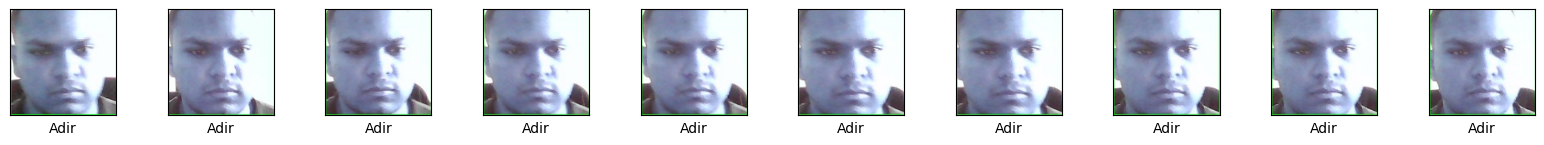

In [106]:
reversed_dict = {v: k for k, v in labels.items()}
print(len(X))
plt.figure(figsize=(20,8))
for i in range(10):
    plt.subplot(5, 10, i+1)
    plt.imshow(X[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(reversed_dict.get(y[i])) 
    
plt.show()

In [107]:
X = np.array(X) / 255.0  
y = np.array(y)

if len(X) == 0:
    print("No valid data found. Exiting...")
    exit()

In [108]:
# Split dataset into training & validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# print("Train: ", y_train)
y_train = to_categorical(y_train, num_classes=len(persons))
# print("Train: ", y_train)
# print(type(y_train))
y_val = to_categorical(y_val, num_classes=len(persons))

## Model Training with Transfer Learning

In [110]:
NUM_CLASSES = len(persons)  # Number of classes (persons)

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(NUM_CLASSES, activation='softmax')(x)

In [111]:
# Create the final model
model = Model(inputs=base_model.input, outputs=output_layer)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 134, 134, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 64, 64, 64)        │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 64, 64, 64)        │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 64, 64, 64)        │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 66, 66, 64)        │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 32, 32, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 32, 32, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 32, 32, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 32, 32, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 32, 32, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 32, 32, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 32, 32, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 32, 32, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 32, 32, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,850,242 (90.98 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [113]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [116]:
# Train the model
h = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=16)

# Save the model
model.save('attendance_resnet_model.h5')
print("ResNet50 model trained and saved successfully!")


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - accuracy: 0.8729 - loss: 0.3743 - val_accuracy: 0.8750 - val_loss: 0.4050
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.8891 - loss: 0.3717 - val_accuracy: 0.8750 - val_loss: 0.3971
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.9088 - loss: 0.3211 - val_accuracy: 0.8750 - val_loss: 0.3744
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.8989 - loss: 0.3218 - val_accuracy: 0.8750 - val_loss: 0.3619
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.8702 - loss: 0.3110 - val_accuracy: 0.8750 - val_loss: 0.3397
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.8975 - loss: 0.2731 - val_accuracy: 0.8750 - val_loss: 0.3290
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.9106 - loss: 0.2730 - val_accuracy: 0.9000 - val_loss: 0.3220
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.9148 - loss: 0.2369 - val_accuracy: 0.

ResNet50 model trained and saved successfully!


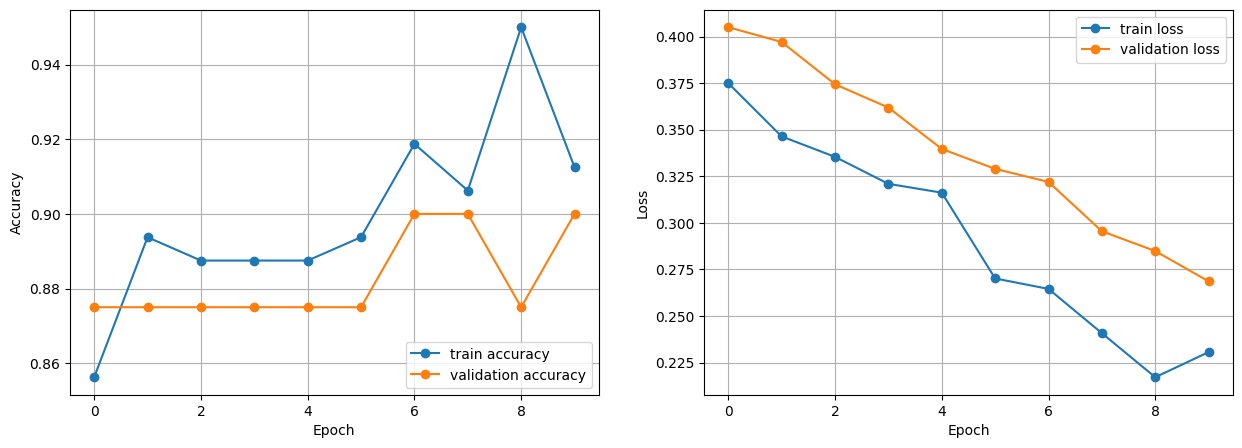

In [117]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], 'o-', label='train accuracy')
plt.plot(h.history['val_accuracy'], 'o-', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], 'o-', label='train loss')
plt.plot(h.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

## Real-Time Face Recognition

In [118]:
# Load trained model
model = load_model('attendance_resnet_model.h5')
# Start webcam
cap = cv2.VideoCapture(0)

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Error: Could not read frame from webcam.")
            break

        # Convert frame to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect faces
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(50, 50))

        for (x, y, w, h) in faces:
            # Draw rectangle around the detected face
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # Preprocess face for model
            face_roi = frame[y:y+h, x:x+w]
            face_roi = cv2.resize(face_roi, (IMG_SIZE, IMG_SIZE))
            face_roi = np.expand_dims(face_roi, axis=0) / 255.0

            # Predict person
            predictions = model.predict(face_roi)
            person_index = np.argmax(predictions)
            confidence = np.max(predictions)

            label = list(labels.keys())[person_index] if confidence > 0.7 else "Unidentified"

            # Display result
            cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        cv2.imshow("Face Recognition - Press 'Q' to Quit", frame)

        # Check for quit command
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):  # Press 'q' to exit
            print("\n[INFO] Quitting application...")
            break

except KeyboardInterrupt:
    print("\n[INFO] Keyboard Interrupt detected. Exiting gracefully...")

finally:
    # Release resources and close windows
    cap.release()
    cv2.destroyAllWindows()
    print("[INFO] Resources released. Application closed.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━